# Explorativa Data Analysis

**Rossmann Store Sales**
Forecast sales using store, promotion, and competitor data

This is a Kaggle competition and can be found [here](https://www.kaggle.com/competitions/rossmann-store-sales/overview)

# Libraries

In [43]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Functions

In [44]:
def mean_encode(df: pd.DataFrame, feature: str, target: str):
    """
    df: dataframe with "feature" and "target" columns
    feature: feature to transform
    target: target variable
    ---------
    return:
    pd.Dataframe with the "target" means groupped by "feature"
    """
    new_col_name = feature + "_mean"
    df_enc = (
        # select columns
        df.loc[:, [feature, target]]
        # group by feature
        .groupby(feature)
        # aggregate over feature using target mean
        .agg(tmp_name=(target, np.mean))
        # index (i.e., feature categories) as a column
        .reset_index()
        # rename the column with the aggregated means
        .rename(columns={"tmp_name":new_col_name})
    )

    # merge: add the new column with the aggregated mean from
    # "df_enc" back into "df"
    df_merged = pd.merge(df, df_enc, how="left", on=feature)

    return df_merged


def mean_encode_2(df: pd.DataFrame, feature1: str, feature2: str, target: str):
    """
    Same as "mean_encode" but with 2 features.
    df: dataframe with "feature" and "target" columns
    feature1: first feature to create a new column with the "target" means
    feature2: second feature to create a new column with the "target" means
    target: target variable
    ---------
    return:
    pd.Dataframe with the "target" means groupped by "feature1" and "feature2"
    """
    new_col_name = feature1 + feature2 + "_mean"
    df_enc = (
        # select columns
        df.loc[:, [feature1, feature2, target]]
        # group by feature
        .groupby([feature1, feature2])
        # aggregate over feature using target mean
        .agg(tmp_name = (target, np.mean))
        # index (i.e., feature categories) as a column
        .reset_index()
        # rename the column with the aggregated means
        .rename(columns={"tmp_name":new_col_name})
        )

    # merge: add the new column with the aggregated mean from
    # "df_enc" back into "df"
    df_merged = pd.merge(df, df_enc, how="left", on=[feature1, feature2])

    return df_merged


def convert_to_others(df: pd.DataFrame, feature: str, N_counts: int):
    """
    df: data frame
    feature: feature to transform
    N_counts: categories with less than "N_counts" counts are converted to "others" 
    """

    df_count = (
        df
        .groupby(feature)[feature]
        .value_counts()
        .reset_index()
    )

    # Select the categories with less than N_counts
    df_other = df_count.loc[df_count["count"] < N_counts, feature]

    # Name for the new column with some categories converted to "others"
    new_col_name = feature + "_others"

    # Copy original column
    df[new_col_name] = df[feature]
    # Categories with less than "N_counts" counts (this info is #
    # stored in the data frame "df_other") are set to "others"
    df.loc[df[feature].isin(df_other), [new_col_name]] = "others"

    return df


def print_NA_info(df: pd.DataFrame, feature:str):
    print(f"Number of unique values: {len(df[feature].unique())}")
    print(f"Unique values: {df[feature].unique()}")
    print(f"Shape train data: {df.shape}")
    na_per = ((df[feature].isna().sum() / len(df[feature])) * 100).round(2)
    print(f"The percentage of NA is: {na_per}%", end="\n\n")
    ##
    print(
        df
        .groupby(feature)[feature]
        .count()
    )

# Load data

In [45]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)


dataset_path = Path().absolute() / "data"

# Load dataset
filename = "store.csv"
store = load_ds(dataset_path, filename)

# Load dataset
filename = "train.csv"
train = load_ds(dataset_path, filename)

/tmp/ipykernel_9344/3563638345.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path / filename)


In [46]:
print(f"Shape store data set: {store.shape}")
print(f"Shape train data set: {train.shape}")

Shape store data set: (1115, 10)
Shape train data set: (1017209, 9)


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [48]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [49]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [50]:
print(f"There are {train.shape[0]} rows in 'train'")
print(f"Number of rows where 'train.Store' is in 'store.Store' {sum(train.Store.isin(store.Store))}")

There are 1017209 rows in 'train'
Number of rows where 'train.Store' is in 'store.Store' 1017209


In [51]:
train.Store

0             1
1             2
2             3
3             4
4             5
           ... 
1017204    1111
1017205    1112
1017206    1113
1017207    1114
1017208    1115
Name: Store, Length: 1017209, dtype: int64

In [52]:
store.Store

0          1
1          2
2          3
3          4
4          5
        ... 
1110    1111
1111    1112
1112    1113
1113    1114
1114    1115
Name: Store, Length: 1115, dtype: int64

In [53]:
train_store = train.merge(store, on="Store")

In [54]:
train_store.shape

(1017209, 18)

In [55]:
train_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [56]:
(train_store.isna().sum() / train_store.shape[0]).reset_index()

,index,0
0,Store,0.000000
1,DayOfWeek,0.000000
2,Date,0.000000
3,Sales,0.000000
4,Customers,0.000000
5,Open,0.000000
6,Promo,0.000000
7,StateHoliday,0.000000
8,SchoolHoliday,0.000000
9,StoreType,0.000000


Remove the rows where `Sales is NA or 0`

In [57]:
# train_store = train_store.loc[~train_store.Sales.isna(), :]
train_store = train_store.loc[train_store.Sales != 0, :]

In [58]:
train_store.iloc[:,:8].head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday
0,1,5,2015-07-31,5263,555,1,1,0
1,1,4,2015-07-30,5020,546,1,1,0
2,1,3,2015-07-29,4782,523,1,1,0
3,1,2,2015-07-28,5011,560,1,1,0
4,1,1,2015-07-27,6102,612,1,1,0
6,1,6,2015-07-25,4364,500,1,0,0
7,1,5,2015-07-24,3706,459,1,0,0
8,1,4,2015-07-23,3769,503,1,0,0
9,1,3,2015-07-22,3464,463,1,0,0
10,1,2,2015-07-21,3558,469,1,0,0


In [59]:
train_store.iloc[:,8:13].head(10)

,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth
0,1,c,a,1270.0,9.0
1,1,c,a,1270.0,9.0
2,1,c,a,1270.0,9.0
3,1,c,a,1270.0,9.0
4,1,c,a,1270.0,9.0
6,0,c,a,1270.0,9.0
7,0,c,a,1270.0,9.0
8,0,c,a,1270.0,9.0
9,0,c,a,1270.0,9.0
10,0,c,a,1270.0,9.0


In [60]:
train_store.iloc[:,13:].head(10)

,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2008.0,0,NaN,NaN,NaN
1,2008.0,0,NaN,NaN,NaN
2,2008.0,0,NaN,NaN,NaN
3,2008.0,0,NaN,NaN,NaN
4,2008.0,0,NaN,NaN,NaN
6,2008.0,0,NaN,NaN,NaN
7,2008.0,0,NaN,NaN,NaN
8,2008.0,0,NaN,NaN,NaN
9,2008.0,0,NaN,NaN,NaN
10,2008.0,0,NaN,NaN,NaN


# Check duplicates

In [61]:
train_store.duplicated().sum()

0

# Split train/test set

In [62]:
# Split train and test data
X_y_train, X_y_test = train_test_split(train_store, test_size=0.2, random_state=123, shuffle=True)

X_y_train = X_y_train.reset_index(drop=True)
X_y_test = X_y_test.reset_index(drop=True)

print(f"shape data: {train_store.shape}")

print(f"\nExpected rows: {train_store.shape[0]} * 0.8 = {train_store.shape[0] * 0.8:.2f}")
print(f"shape X_y_train: {X_y_train.shape}")

print(f"\nExpected rows: {train_store.shape[0]} * 0.2 = {train_store.shape[0] * 0.2:.2f}")
print(f"shape X_y_test: {X_y_test.shape}")

shape data: (844338, 18)

Expected rows: 844338 * 0.8 = 675470.40
shape X_y_train: (675470, 18)

Expected rows: 844338 * 0.2 = 168867.60
shape X_y_test: (168868, 18)


In [63]:
# Save train and test sets
X_y_train.to_csv(Path().absolute() / "data" / "X_y_train.csv", index=False)
X_y_test.to_csv(Path().absolute() / "data" / "X_y_test.csv", index=False)

# EDA

## Sales

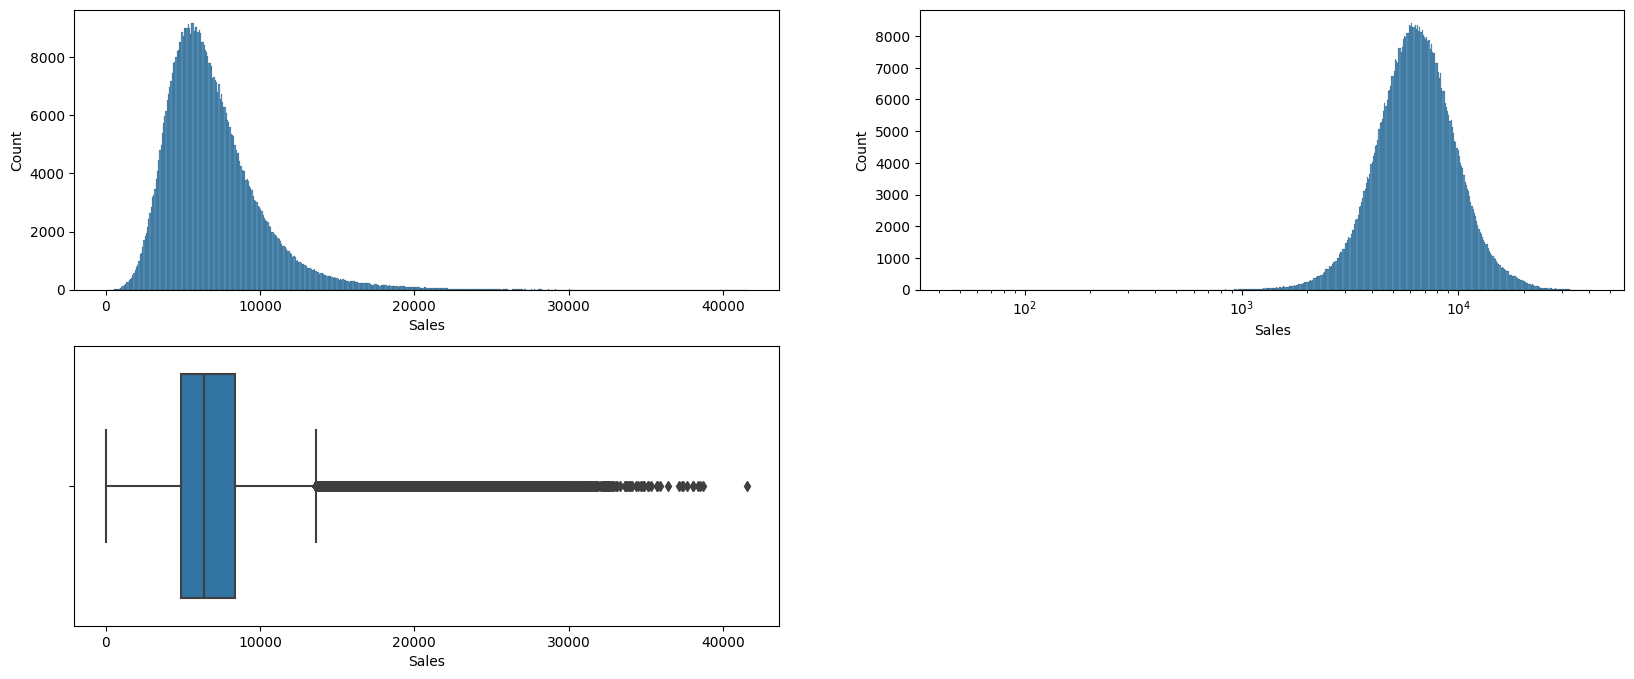

In [65]:
plt.figure(figsize=(20, 8))

plt.subplot(2, 2, 1)
sns.histplot(X_y_train, x="Sales")

plt.subplot(2, 2, 2)
sns.histplot(X_y_train, x="Sales", log_scale=True)

plt.subplot(2, 2, 3)
sns.boxplot(x="Sales", data=X_y_train)

plt.show()

# FINO A QUI!!!!!!!!!!!!!!

## Date

In [23]:
date2 = pd.to_datetime(X_y_train["Date"], format="%Y-%m-%d") # format="%d/%m/%Y"
month = date2.dt.month
year = date2.dt.year
day = date2.dt.day

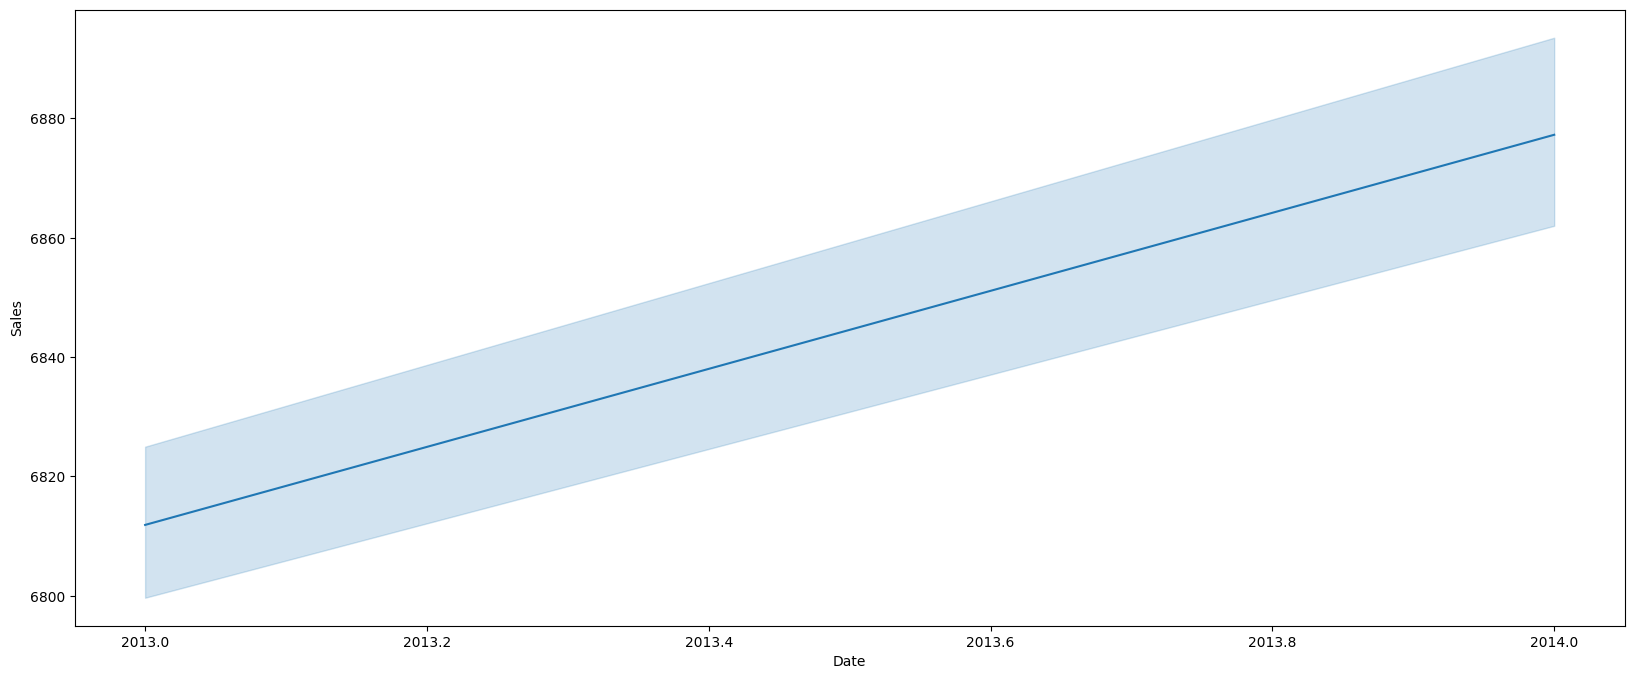

In [24]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=year, y="Sales", data=X_y_train)
# sns.scatterplot(x=month, y="Sales", data=X_y_train)
plt.show()

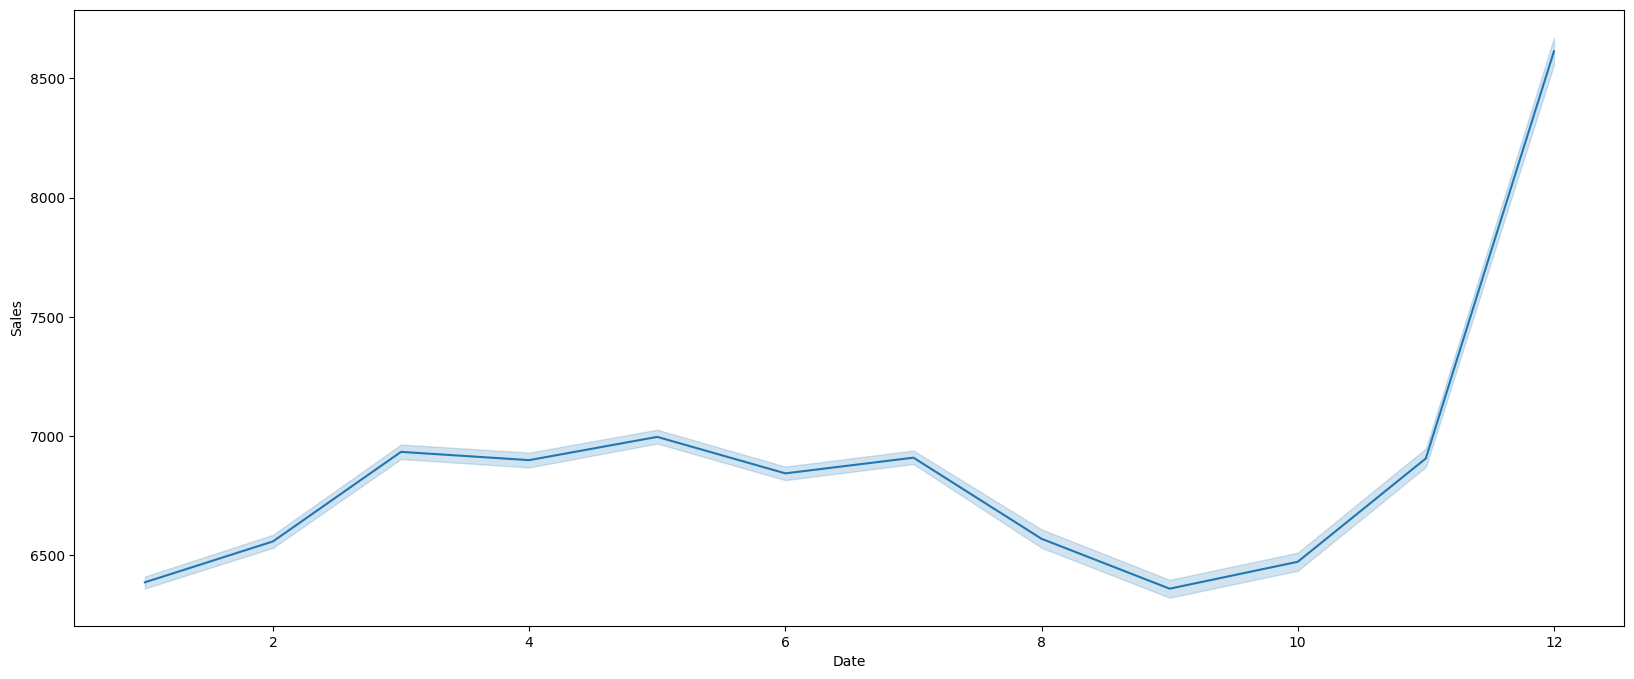

In [25]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=month, y="Sales", data=X_y_train)
# sns.scatterplot(x=month, y="Sales", data=X_y_train)
plt.show()

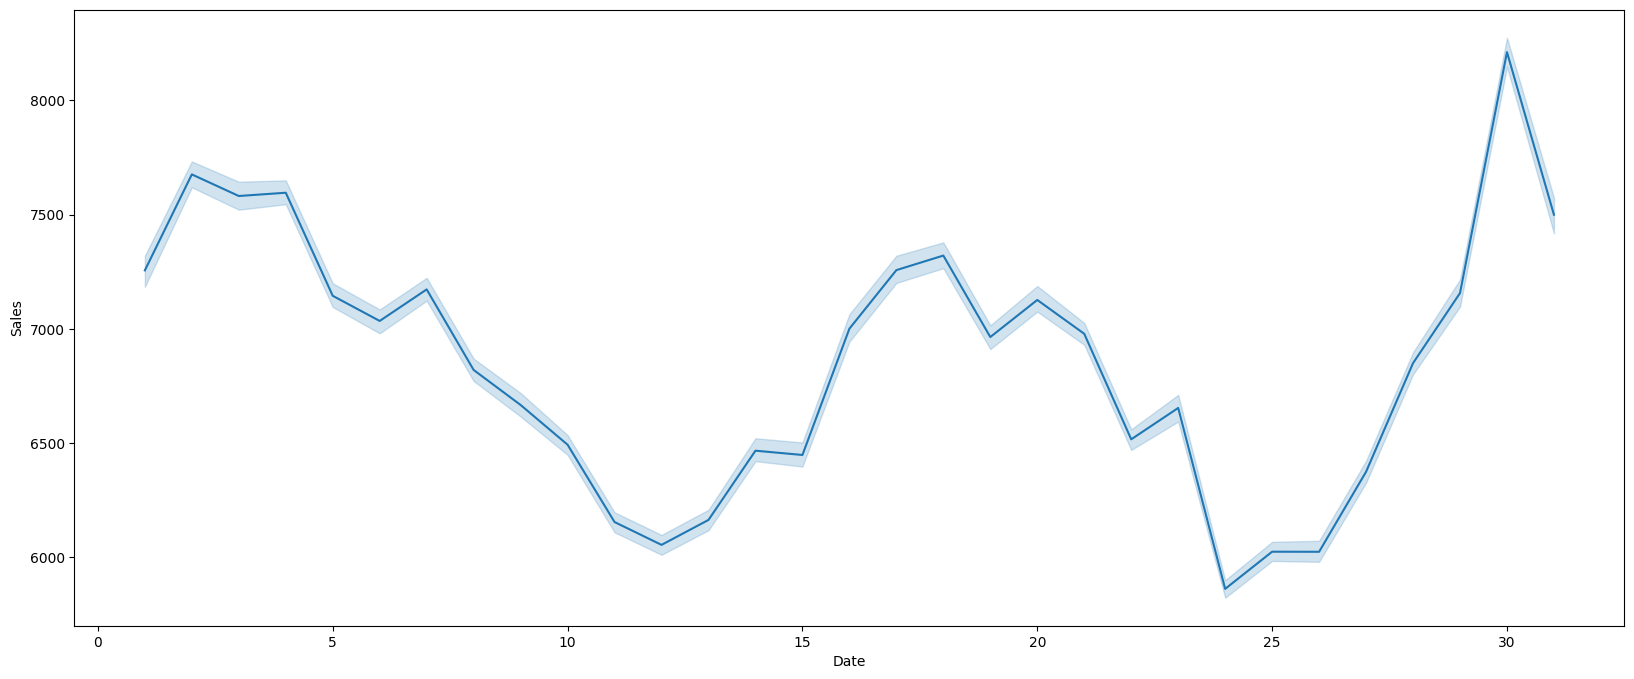

In [26]:
plt.figure(figsize=(20, 8))
sns.lineplot(x=day, y="Sales", data=X_y_train)
plt.show()

## Store

In [27]:
print(f"Number of unique address: {len(X_y_train.Store.unique())}")
print(f"Shape train data: {X_y_train.shape}")

# len(X_y_train.Store.unique())

Number of unique address: 1115
Shape train data: (397900, 18)


In [28]:
df_tmp = mean_encode(X_y_train, "Store", "Sales")

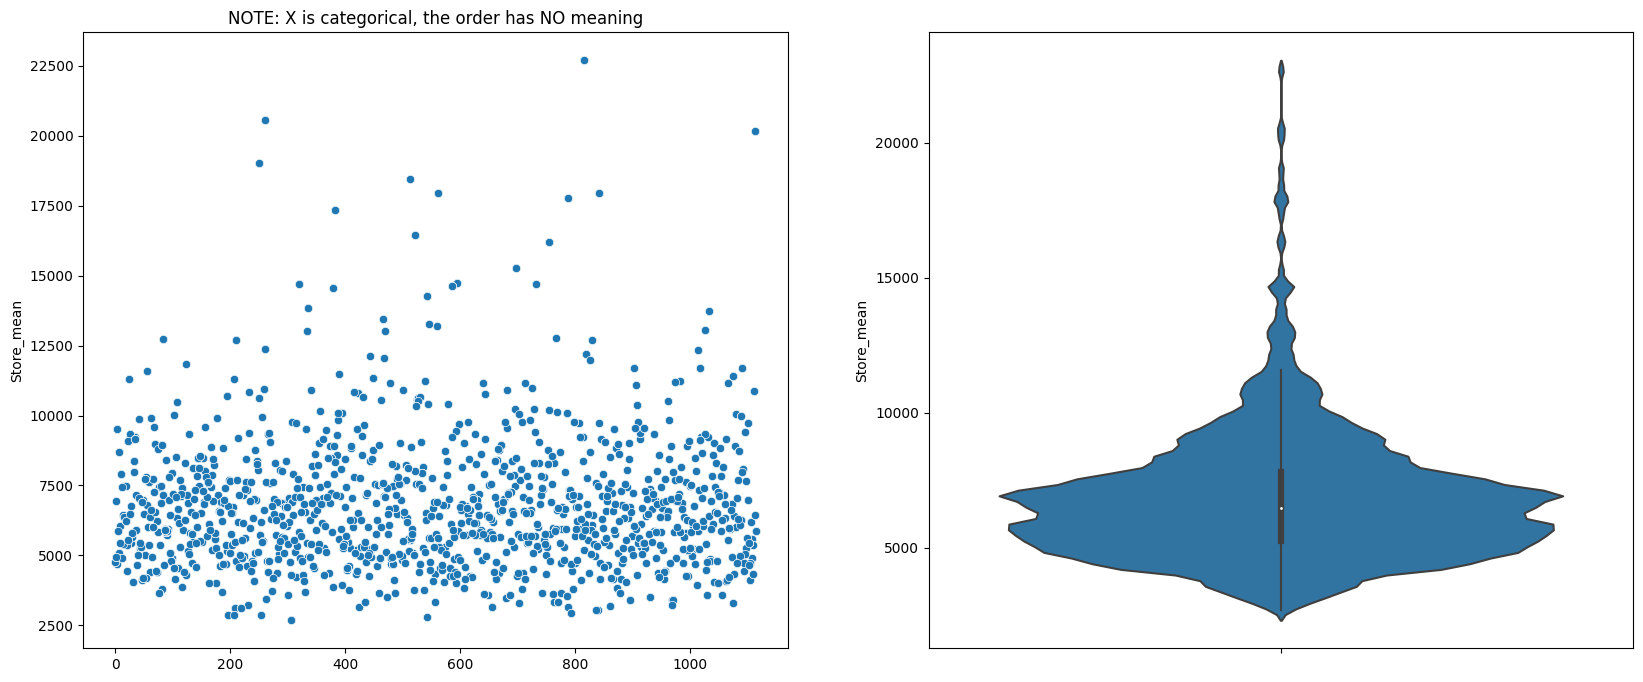

In [29]:
x_plot = pd.Categorical(df_tmp.Store).codes

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_tmp, x=x_plot, y="Store_mean")
plt.title("NOTE: X is categorical, the order has NO meaning")

plt.subplot(1, 2, 2)
sns.violinplot(data=df_tmp, y="Store_mean")

plt.show()

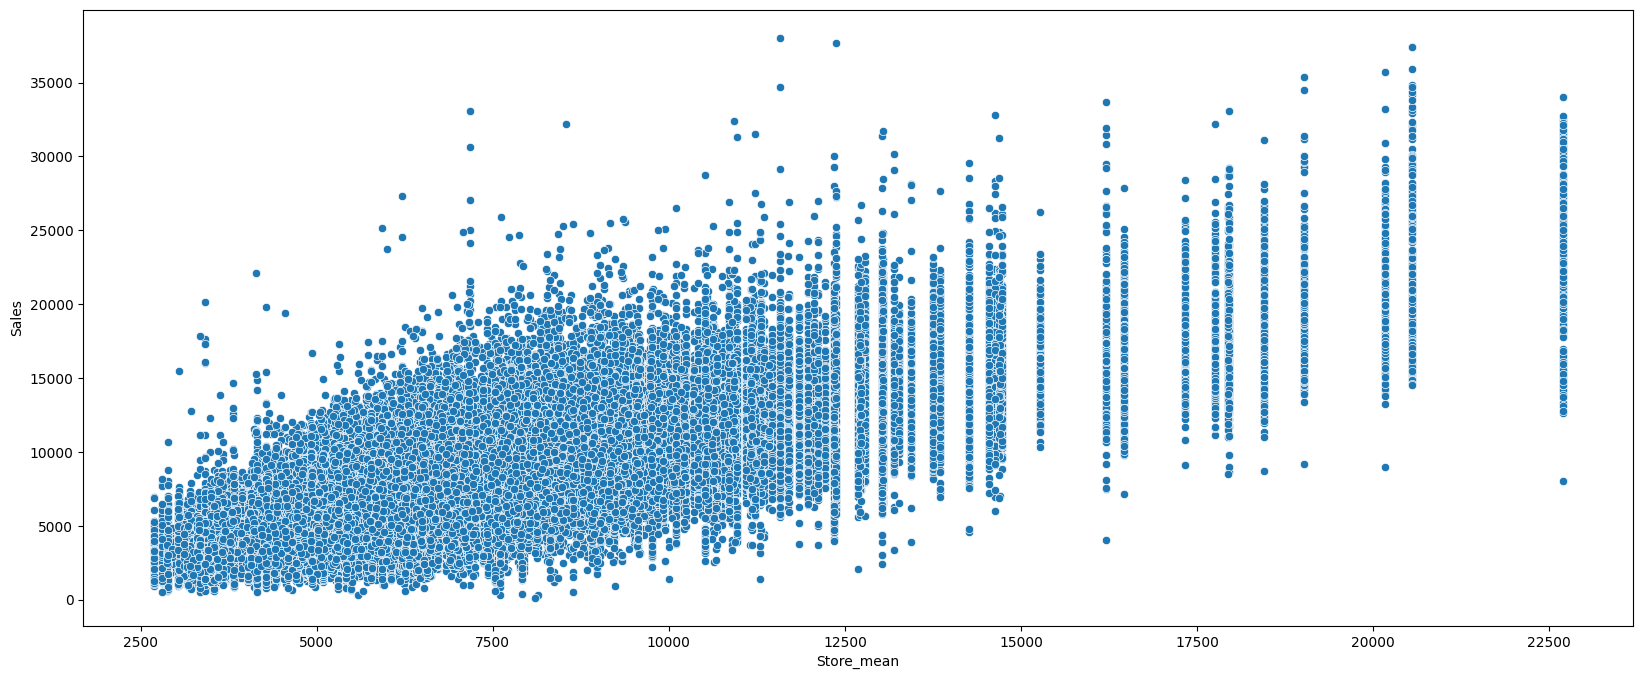

In [30]:
plt.figure(figsize=(20, 8))
# sns.lineplot(x="Store_mean", y="Sales", data=df_tmp)
sns.scatterplot(x="Store_mean", y="Sales", data=df_tmp)
plt.show()

We will use `mean encoding` for `Store`

## DayOfWeek

In [31]:
X_y_train.DayOfWeek

0         4.0
1         NaN
2         5.0
3         1.0
4         4.0
         ... 
397895    1.0
397896    6.0
397897    1.0
397898    4.0
397899    4.0
Name: DayOfWeek, Length: 397900, dtype: float64

In [32]:
(
    X_y_train
    .groupby("DayOfWeek")["DayOfWeek"]
    #.agg(np.mean)
    .count()
)

DayOfWeek
1.0    62518
2.0    66342
3.0    64120
4.0    61502
5.0    63875
6.0    66040
7.0     1642
Name: DayOfWeek, dtype: int64

On Sunday (`DayOfWeek=7`) there are few data compared to the other days

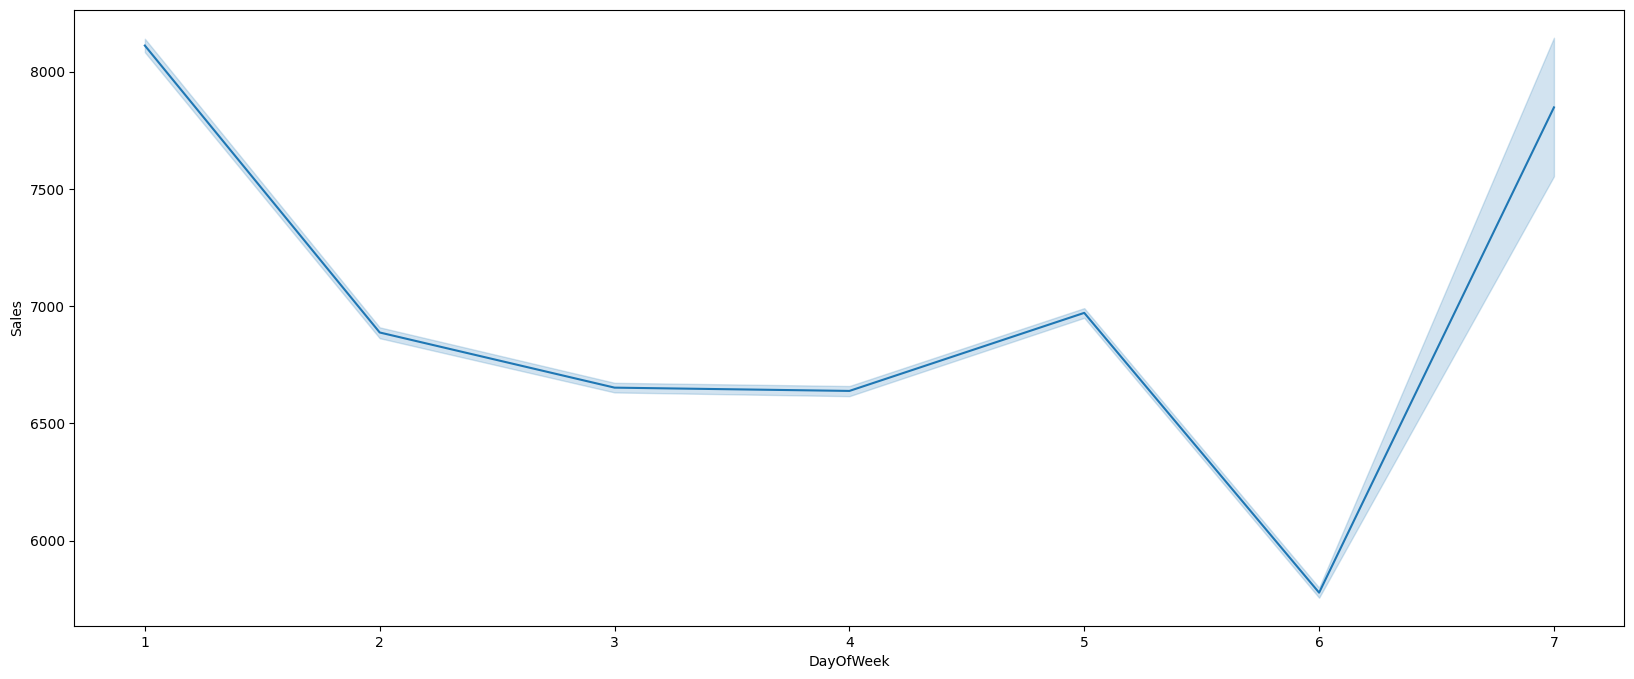

In [33]:
plt.figure(figsize=(20, 8))
sns.lineplot(x="DayOfWeek", y="Sales", data=X_y_train)
plt.show()

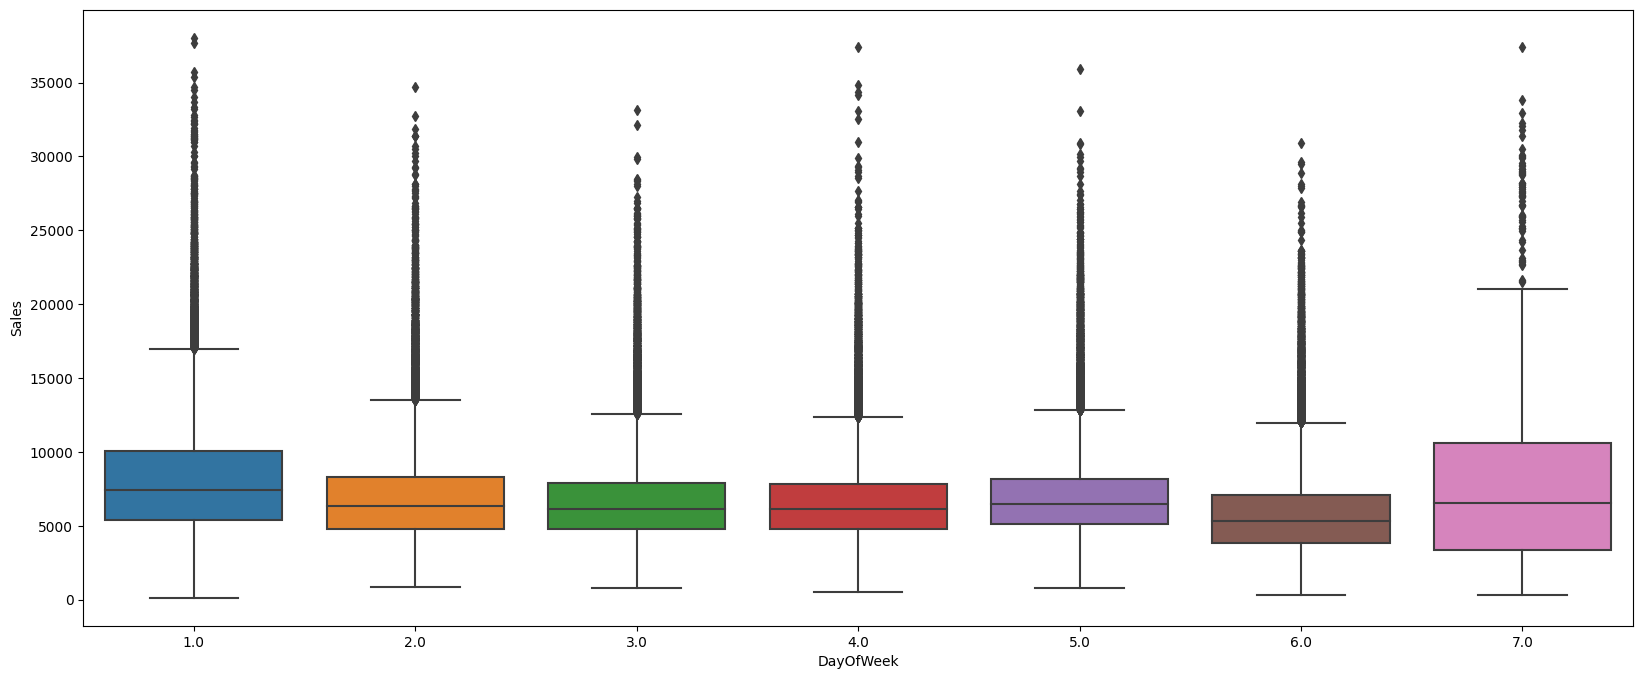

In [34]:
plt.figure(figsize=(20, 8))
# sns.scatterplot(x="DayOfWeek", y="Sales", data=X_y_train)
sns.boxplot(x="DayOfWeek", y="Sales", data=X_y_train)
plt.show()

In [35]:
df_tmp = mean_encode(X_y_train, "DayOfWeek", "Sales")

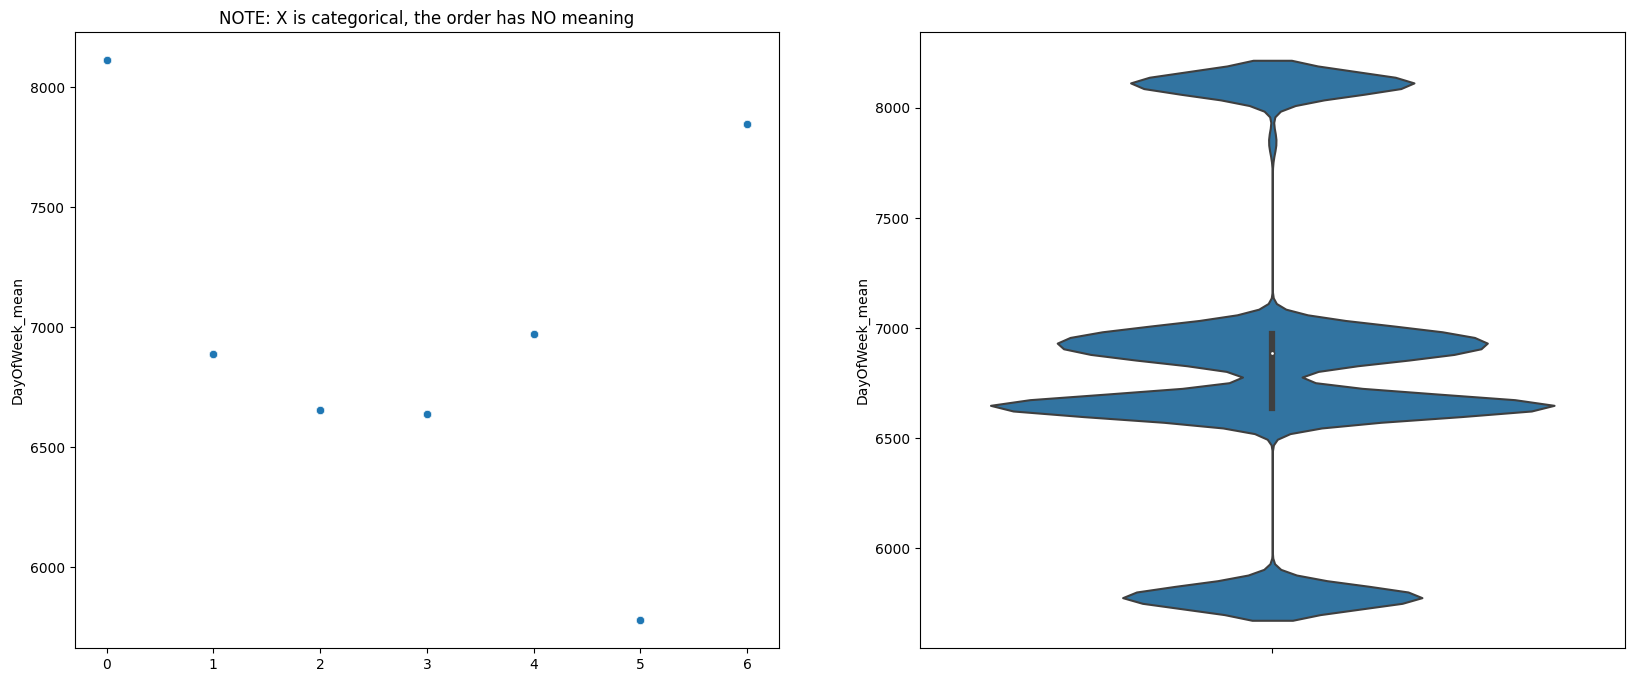

In [36]:
x_plot = pd.Categorical(df_tmp.DayOfWeek).codes

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_tmp, x=x_plot, y="DayOfWeek_mean")
plt.title("NOTE: X is categorical, the order has NO meaning")

plt.subplot(1, 2, 2)
sns.violinplot(data=df_tmp, y="DayOfWeek_mean")

plt.show()

`DayOfWeek_mean` is lower on Saturday

## Customers

In [37]:
X_y_train.Customers

0         1109.0
1          472.0
2          728.0
3         1726.0
4         1127.0
           ...  
397895     696.0
397896     621.0
397897     714.0
397898     995.0
397899     445.0
Name: Customers, Length: 397900, dtype: float64

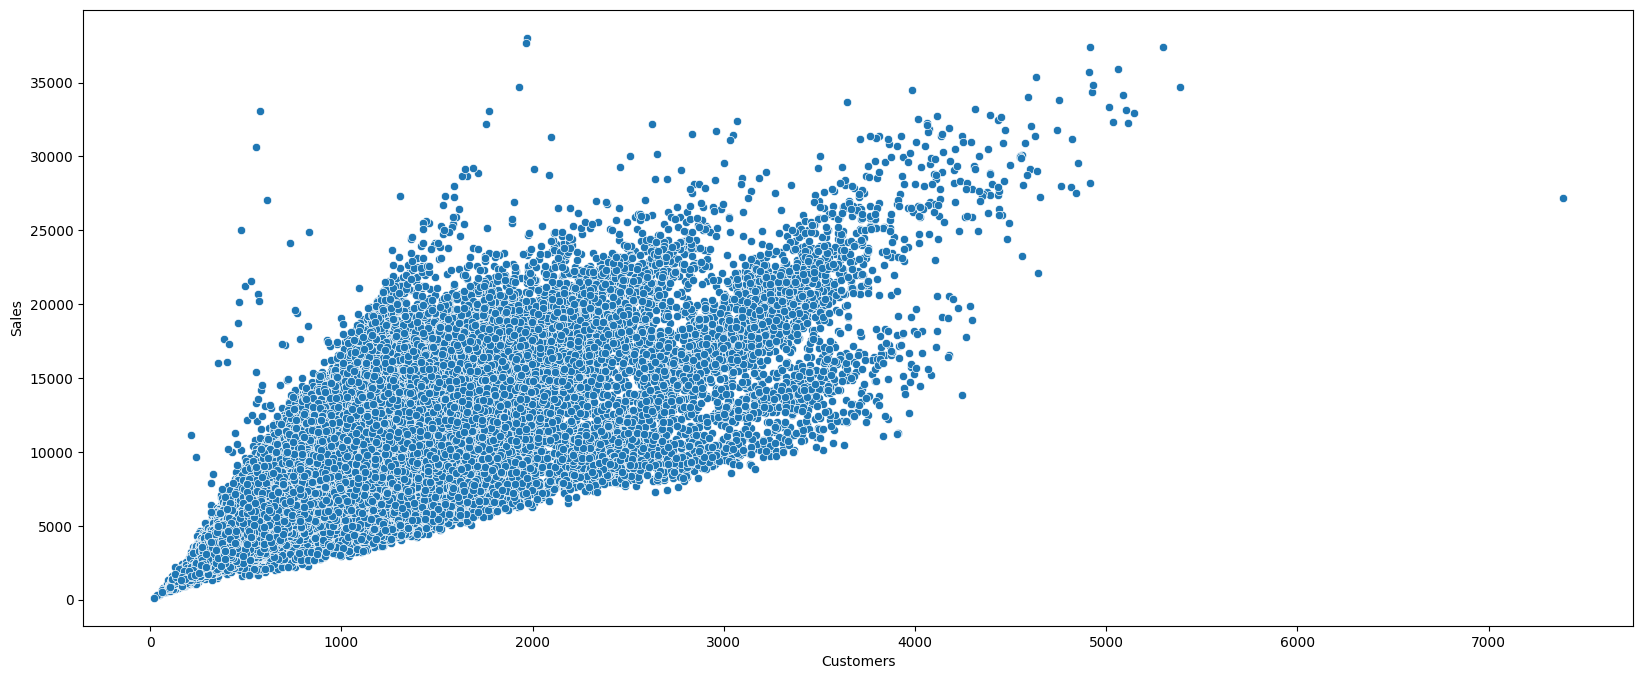

In [38]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x="Customers", y="Sales", data=X_y_train)
plt.show()

`Customers` cannot be used to predict the next day without knowing the number of customers!

## Open

In [39]:
print_NA_info(X_y_train, "Open")

Number of unique values: 2
Unique values: [ 1. nan]
Shape train data: (397900, 18)
The percentage of NA is: 3.02%

Open
1.0    385880
Name: Open, dtype: int64


In [40]:
(
    X_y_train
    .groupby("Open")["Open"]
    .value_counts()
)

Open
1.0    385880
Name: count, dtype: int64

We drop `Open` because it does not add additional info (when the store is close the sales are 0, when it's open this variable does not add useful info)

## Promo

In [41]:
print_NA_info(X_y_train, "Promo")

Number of unique values: 3
Unique values: [ 1.  0. nan]
Shape train data: (397900, 18)
The percentage of NA is: 2.99%

Promo
0.0    218894
1.0    167106
Name: Promo, dtype: int64


In [42]:
a1 = mean_encode_2(X_y_train, "Promo", "Store", "Sales")
a1.loc[:, ["Promo", "Store", "PromoStore_mean"]].head(5)

,Promo,Store,PromoStore_mean
0,1.0,492.0,9252.883212
1,0.0,977.0,3524.360215
2,1.0,912.0,6071.148387
3,1.0,709.0,12340.687500
4,1.0,699.0,9640.649682


In [43]:
a1 = (
    X_y_train
    .groupby(["Promo", "Store"])
    .agg(mean=("Sales", np.mean))
    .reset_index()
    .pivot(index='Store', columns="Promo", values="mean")
    .rename(columns={0.0:"0", 1.0:"1"})
)

a1["diff"] = a1["1"] - a1["0"]

a1.head(5)

Promo,0,1,diff
Store,,,
1.0,4322.727723,5358.378205,1035.650482
2.0,3883.967568,6278.136364,2394.168796
3.0,5369.828877,8900.235294,3530.406417
4.0,8746.244898,10482.024845,1735.779947
5.0,3487.584211,6179.734177,2692.149967


For each store, how much the `Promo=1` add to the mean Sales compared to when `Promo=0`

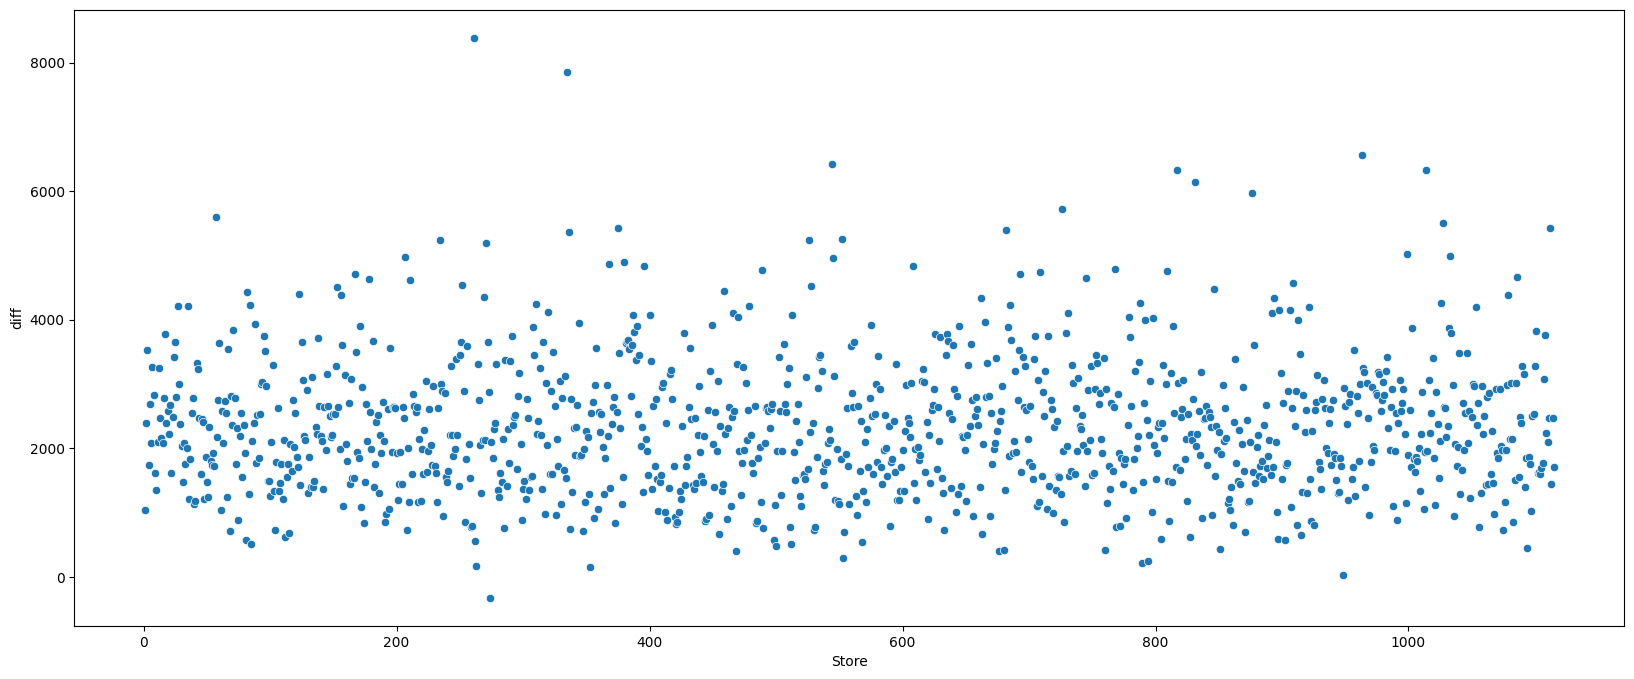

In [44]:
plt.figure(figsize=(20, 8))
sns.scatterplot(x="Store", y="diff", data=a1)
plt.show()

## StateHoliday

- a = public holiday
- b = Easter holiday
- c = Christmas
- 0 = None

In [45]:
print_NA_info(X_y_train, "StateHoliday")

Number of unique values: 6
Unique values: ['0' 0.0 nan 'b' 'c' 'a']
Shape train data: (397900, 18)
The percentage of NA is: 3.03%

StateHoliday
0.0     40874
0      344552
a         326
b          67
c          29
Name: StateHoliday, dtype: int64


In [46]:
X_y_train.loc[X_y_train.StateHoliday==0.0, "StateHoliday"] = "0"

In [47]:
print_NA_info(X_y_train, "StateHoliday")

Number of unique values: 5
Unique values: ['0' nan 'b' 'c' 'a']
Shape train data: (397900, 18)
The percentage of NA is: 3.03%

StateHoliday
0    385426
a       326
b        67
c        29
Name: StateHoliday, dtype: int64


In [48]:
(
    X_y_train
    .groupby("StateHoliday")["StateHoliday"]
    .count()
)

StateHoliday
0    385426
a       326
b        67
c        29
Name: StateHoliday, dtype: int64

There are few data on holidays, we should merge `a`, `b` and `c`.

In [49]:
X_y_train["StateHoliday_merged"] = X_y_train["StateHoliday"].copy()
print(X_y_train["StateHoliday_merged"].unique())
X_y_train.loc[X_y_train.StateHoliday_merged=="0", "StateHoliday_merged"] = "NotHoliday"
X_y_train.loc[X_y_train.StateHoliday_merged=="a", "StateHoliday_merged"] = "Holiday"
X_y_train.loc[X_y_train.StateHoliday_merged=="b", "StateHoliday_merged"] = "Holiday"
X_y_train.loc[X_y_train.StateHoliday_merged=="c", "StateHoliday_merged"] = "Holiday"

['0' nan 'b' 'c' 'a']


In [50]:
print(X_y_train["StateHoliday_merged"].unique())

['NotHoliday' nan 'Holiday']


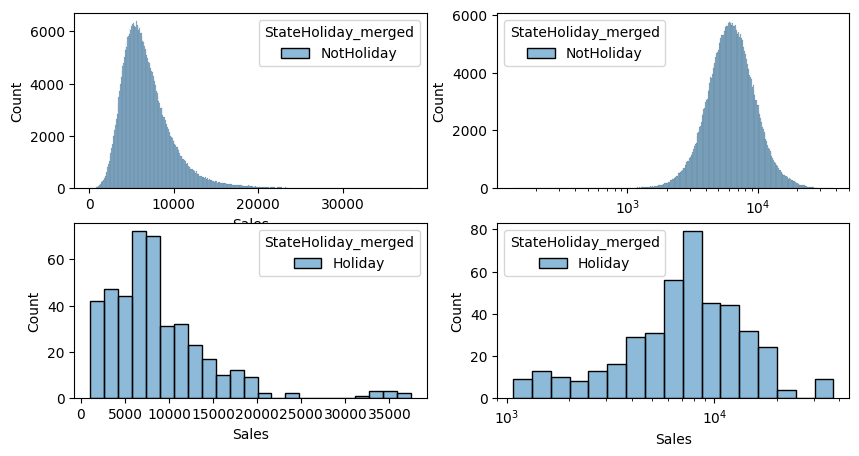

In [51]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
sns.histplot(X_y_train.loc[X_y_train.StateHoliday_merged=="NotHoliday", :], x="Sales", hue="StateHoliday_merged")

plt.subplot(2, 2, 2)
sns.histplot(
    X_y_train.loc[X_y_train.StateHoliday_merged=="NotHoliday", :],
    x="Sales",
    log_scale=True,
    hue="StateHoliday_merged")

plt.subplot(2, 2, 3)
sns.histplot(X_y_train.loc[X_y_train.StateHoliday_merged=="Holiday", :], x="Sales", hue="StateHoliday_merged")

plt.subplot(2, 2, 4)
sns.histplot(
    X_y_train.loc[X_y_train.StateHoliday_merged=="Holiday", :],
    x="Sales",
    log_scale=True,
    hue="StateHoliday_merged")

plt.show()

## SchoolHoliday

In [52]:
print_NA_info(X_y_train, "SchoolHoliday")

Number of unique values: 3
Unique values: [ 0.  1. nan]
Shape train data: (397900, 19)
The percentage of NA is: 3.04%

SchoolHoliday
0.0    313581
1.0     72236
Name: SchoolHoliday, dtype: int64


In [53]:
X_y_train.loc[X_y_train.SchoolHoliday=="0", :] = 0.0

In [54]:
print_NA_info(X_y_train, "SchoolHoliday")

Number of unique values: 3
Unique values: [ 0.  1. nan]
Shape train data: (397900, 19)
The percentage of NA is: 3.04%

SchoolHoliday
0.0    313581
1.0     72236
Name: SchoolHoliday, dtype: int64


In [55]:
(
    X_y_train
    .groupby("SchoolHoliday")["SchoolHoliday"]
    .count()
)

SchoolHoliday
0.0    313581
1.0     72236
Name: SchoolHoliday, dtype: int64

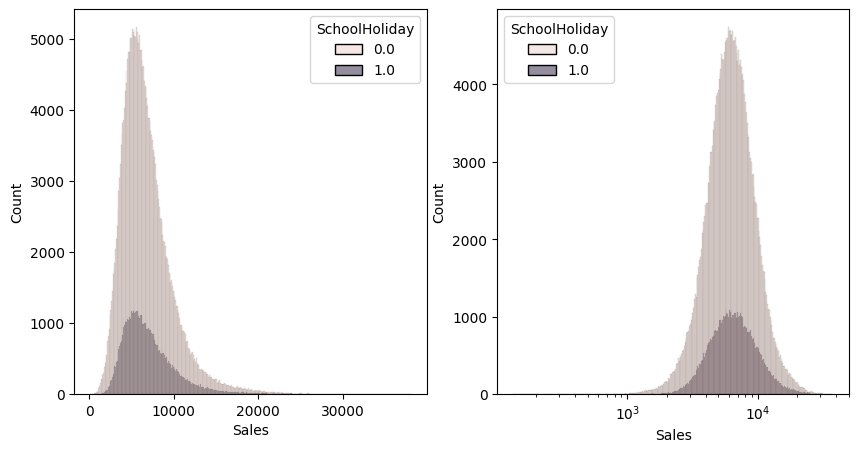

In [56]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(X_y_train, x="Sales", hue="SchoolHoliday")

plt.subplot(1, 2, 2)
sns.histplot(X_y_train, x="Sales", log_scale=True, hue="SchoolHoliday")

plt.show()

## StoreType

In [57]:
print_NA_info(X_y_train, "StoreType")

Number of unique values: 4
Unique values: ['a' 'c' 'd' 'b']
Shape train data: (397900, 19)
The percentage of NA is: 0.0%

StoreType
a    214749
b      7209
c     52594
d    123348
Name: StoreType, dtype: int64


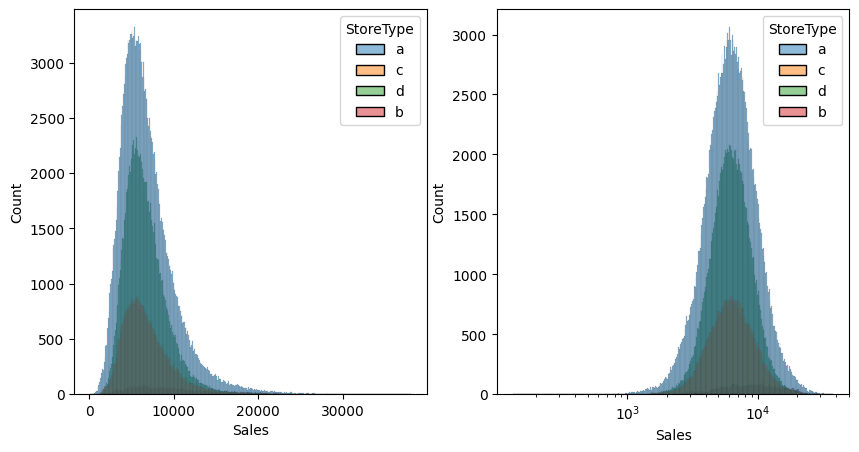

In [58]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(X_y_train, x="Sales", hue="StoreType")

plt.subplot(1, 2, 2)
sns.histplot(X_y_train, x="Sales", log_scale=True, hue="StoreType")

plt.show()

## Assortment

In [59]:
print_NA_info(X_y_train, "Assortment")

Number of unique values: 3
Unique values: ['a' 'c' 'b']
Shape train data: (397900, 19)
The percentage of NA is: 0.0%

Assortment
a    210884
b      3855
c    183161
Name: Assortment, dtype: int64


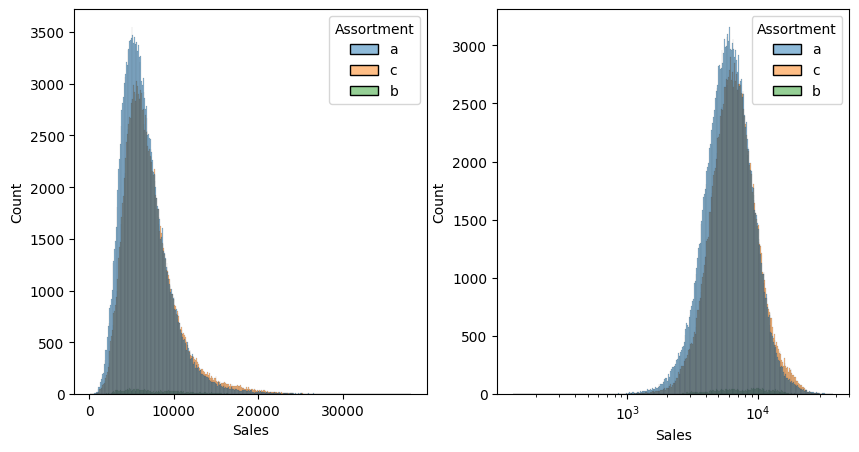

In [60]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(X_y_train, x="Sales", hue="Assortment")

plt.subplot(1, 2, 2)
sns.histplot(X_y_train, x="Sales", log_scale=True, hue="Assortment")

plt.show()

## CompetitionDistance

In [61]:
X_y_train["CompetitionDistance"].isna().sum()

1036

In [62]:
X_y_train["CompetitionDistance"].describe()

count    396864.000000
mean       5438.120364
std        7769.046813
min          20.000000
25%         720.000000
50%        2320.000000
75%        6890.000000
max       75860.000000
Name: CompetitionDistance, dtype: float64

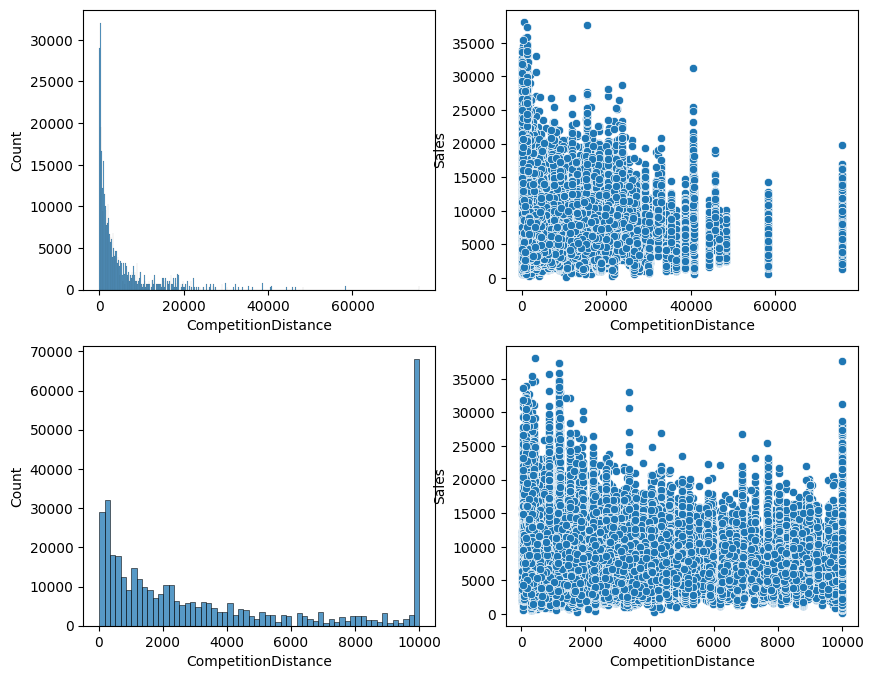

In [63]:
clip_upper = 10000
plot_x = X_y_train["CompetitionDistance"].clip(upper=clip_upper)

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.histplot(X_y_train, x="CompetitionDistance")

plt.subplot(2, 2, 2)
sns.scatterplot(x="CompetitionDistance", y="Sales", data=X_y_train)

plt.subplot(2, 2, 3)

sns.histplot(X_y_train, x=plot_x)

plt.subplot(2, 2, 4)
sns.scatterplot(x=plot_x, y="Sales", data=X_y_train)

plt.show()

In [64]:
n_bins = 10
clip_upper = 10000
CompetitionDistance_clip = X_y_train["CompetitionDistance"].clip(upper=clip_upper)
#Distance_bins = pd.cut(X_y_train["CompetitionDistance"], bins=n_bins, labels=[i for i in range(n_bins)])
Distance_bins = pd.cut(CompetitionDistance_clip, bins=n_bins, labels=[i for i in range(n_bins)])
Distance_bins.describe()

count     396864
unique        10
top            0
freq      118436
Name: CompetitionDistance, dtype: int64

In [65]:
Distance_bins_2 = (
    Distance_bins
    .value_counts()
    .reset_index()
)
Distance_bins_2

,CompetitionDistance,count
0,0,118436
1,9,75547
2,1,60884
3,2,44066
4,3,27916
5,4,21389
6,5,15253
7,6,12185
8,8,12011
9,7,9177


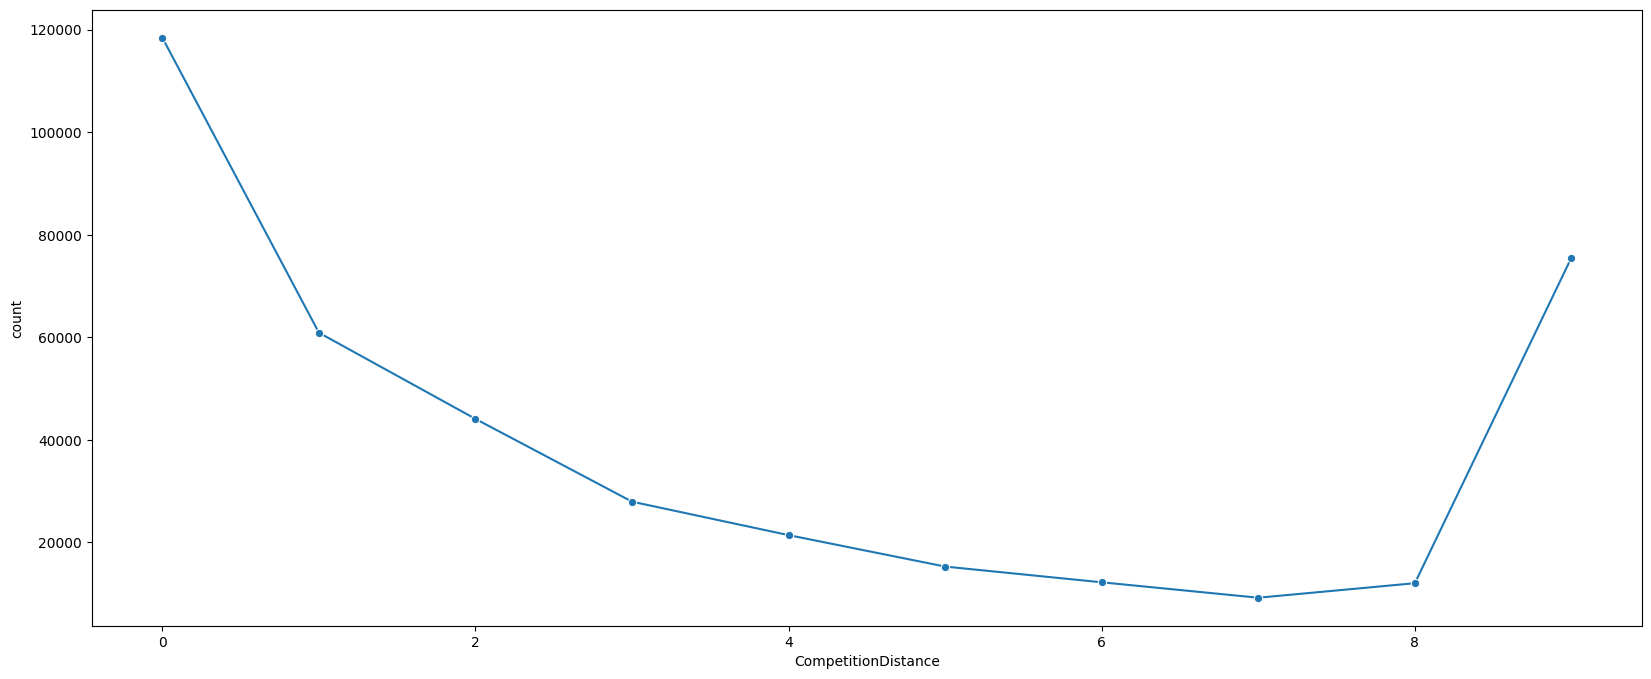

In [66]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=Distance_bins_2, x="CompetitionDistance", y="count", marker="o")
plt.show()

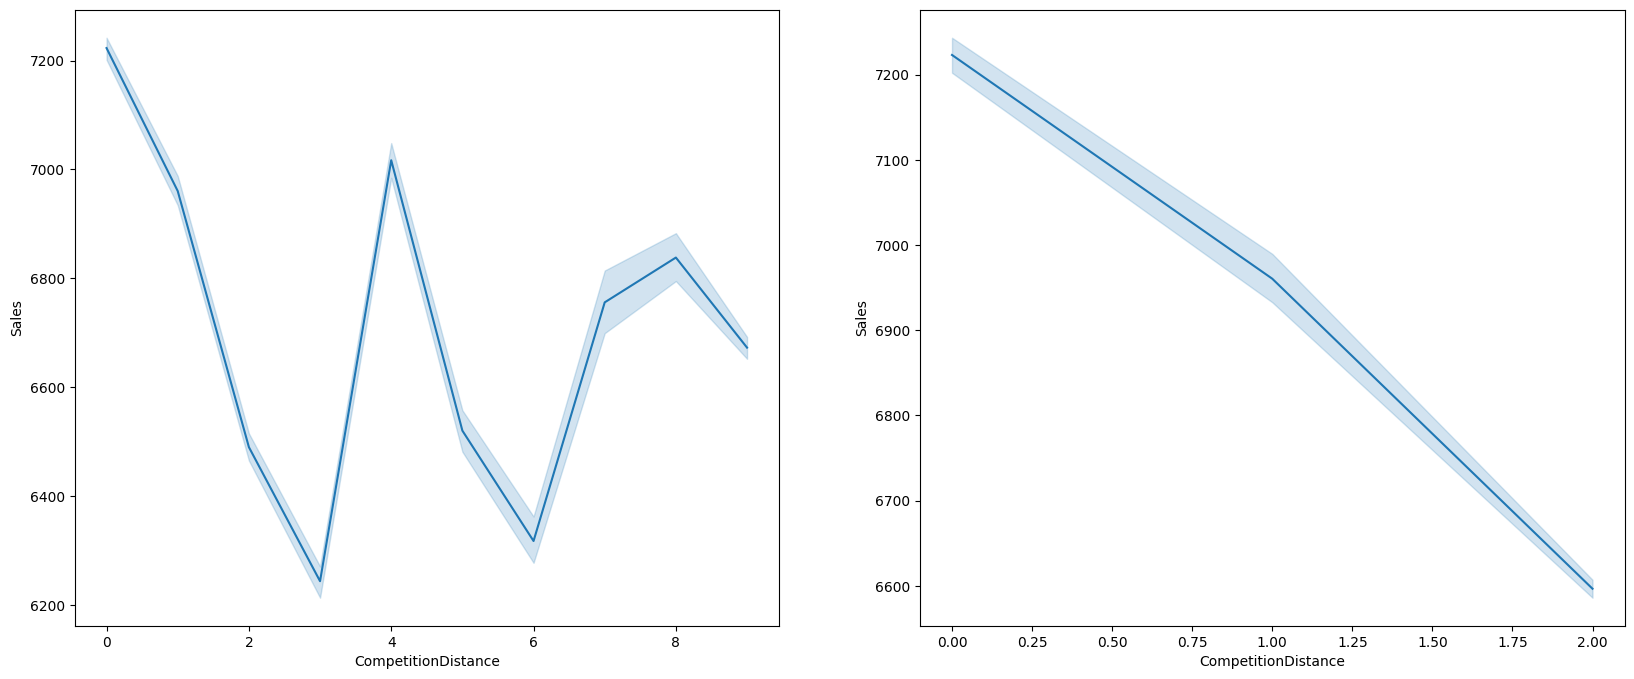

In [67]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.lineplot(x=Distance_bins, y="Sales", data=X_y_train)

plt.subplot(1, 2, 2)
plot_x = Distance_bins.clip(upper=2)
sns.lineplot(x=plot_x, y="Sales", data=X_y_train)

plt.show()

## CompetitionOpenSinceMonth

In [68]:
X_y_train["CompetitionOpenSinceMonth"].head(10)

0     3.0
1     9.0
2     5.0
3    12.0
4     NaN
5     NaN
6     6.0
7     3.0
8     8.0
9     4.0
Name: CompetitionOpenSinceMonth, dtype: float64

In [69]:
X_y_train["CompetitionOpenSinceMonth"].describe()

count    271565.000000
mean          7.227614
std           3.211592
min           1.000000
25%           4.000000
50%           8.000000
75%          10.000000
max          12.000000
Name: CompetitionOpenSinceMonth, dtype: float64

In [70]:
print_NA_info(X_y_train, "CompetitionOpenSinceMonth")

Number of unique values: 13
Unique values: [ 3.  9.  5. 12. nan  6.  8.  4. 11.  7. 10.  2.  1.]
Shape train data: (397900, 19)
The percentage of NA is: 31.75%

CompetitionOpenSinceMonth
1.0      4955
2.0     14673
3.0     24849
4.0     33850
5.0     15612
6.0     17866
7.0     23419
8.0     13908
9.0     44839
10.0    21859
11.0    32895
12.0    22840
Name: CompetitionOpenSinceMonth, dtype: int64


## CompetitionOpenSinceYear

In [71]:
X_y_train["CompetitionOpenSinceYear"].head(10)

0    2008.0
1    2005.0
2    2010.0
3    2010.0
4       NaN
5       NaN
6    2015.0
7    2012.0
8    2001.0
9    2015.0
Name: CompetitionOpenSinceYear, dtype: float64

In [72]:
X_y_train["CompetitionOpenSinceYear"].describe()

count    271565.000000
mean       2008.679101
std           6.132341
min        1900.000000
25%        2006.000000
50%        2010.000000
75%        2013.000000
max        2015.000000
Name: CompetitionOpenSinceYear, dtype: float64

In [73]:
print_NA_info(X_y_train, "CompetitionOpenSinceYear")

Number of unique values: 24
Unique values: [2008. 2005. 2010.   nan 2015. 2012. 2001. 2013. 2009. 2011. 2014. 2006.
 1990. 2002. 2003. 1900. 2007. 1999. 2000. 2004. 1998. 1994. 1995. 1961.]
Shape train data: (397900, 19)
The percentage of NA is: 31.75%

CompetitionOpenSinceYear
1900.0      344
1961.0      340
1990.0     1746
1994.0      724
1995.0      717
1998.0      349
1999.0     2922
2000.0     3576
2001.0     5678
2002.0     9732
2003.0     6727
2004.0     7826
2005.0    22087
2006.0    16730
2007.0    17023
2008.0    19066
2009.0    19264
2010.0    19915
2011.0    19503
2012.0    29160
2013.0    29766
2014.0    25009
2015.0    13361
Name: CompetitionOpenSinceYear, dtype: int64


## Promo2

In [74]:
print_NA_info(X_y_train, "Promo2")

Number of unique values: 2
Unique values: [1 0]
Shape train data: (397900, 19)
The percentage of NA is: 0.0%

Promo2
0    195986
1    201914
Name: Promo2, dtype: int64


In [75]:
a1 = mean_encode_2(X_y_train, "Promo2", "Store", "Sales")
a1.loc[:, ["Promo2", "Store", "Promo2Store_mean"]].head(5)

,Promo2,Store,Promo2Store_mean
0,1,492.0,7735.800000
1,1,977.0,4923.875362
2,0,912.0,5632.132231
3,0,709.0,9761.904762
4,1,699.0,8476.935393


In [76]:
a1 = (
    X_y_train
    .groupby(["Promo2", "Store"])
    .agg(mean=("Sales", np.mean))
    .reset_index()
    .pivot(index='Store', columns="Promo2", values="mean")
    .rename(columns={0.0:"0", 1.0:"1"})
)

a1["diff"] = a1["1"] - a1["0"]

a1.head(5)

Promo2,0,1,diff
Store,,,
1.0,4780.728261,NaN,NaN
2.0,NaN,4962.662890,NaN
3.0,NaN,6959.844828,NaN
4.0,9529.356354,NaN,NaN
5.0,4701.746556,NaN,NaN


In [77]:
print(f"Shape: {a1.shape}")
print(f"Number of NA in '0': {a1['0'].isna().sum()}")
print(f"Number of NA in '1': {a1['1'].isna().sum()}")
print(f"Number of NA in 'diff': {a1['diff'].isna().sum()}")

Shape: (1115, 3)
Number of NA in '0': 571
Number of NA in '1': 544
Number of NA in 'diff': 1115


In the `diff` column all values are `NaN`.

# col

In [78]:
X_y_train.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'StateHoliday_merged'],
      dtype='object')